# Introduction
Recentlym I came across the talk [talk](https://www.youtube.com/watch?v=Q2sM5z_1Lbw) from the Diabolia

Among all the great tips, the [`vmstat`](https://linux.die.net/man/8/vmstat) command line utility seems to deliver great insights when it comes to quick performance analysis of Linux-based systems.

E. g., with a `vmstat 1 60`, `vmstat` will deliver you basic statistics about the utilization of your system frictionless:


It looks like a good idea to have a Jupyter notebook in place that can parse and visualize the data that `vmstat` produces. This could be very handy for quick performance analysis.

# Data input
First, we parse our way through the data. I executed some tasks with high CPU load, downloaded something from the web and and copyied a huge file. I've recorded the results into the text file `vmstat_load.log`, which looks like this:
<code><div style="font-size:10px;">procs -----------------------memory---------------------- ---swap-- -----io---- -system-- --------cpu-------- -----timestamp-----
 r  b         swpd         free         buff        cache   si   so    bi    bo   in   cs  us  sy  id  wa  st                 UTC
 0  0         4680       262868       216292      1513044    0    0     3    28    2   11   2   3  95   1   0 2019-01-13 10:24:27
 0  0         4680       262736       216292      1513052    0    0     0    80  853 6126   3   6  91   1   0 2019-01-13 10:24:28
 0  0         4680       262736       216292      1513052    0    0     0    20  663 5064   1   3  96   0   0 2019-01-13 10:24:29
</div></code><br/>
Yes, it's really ugly kind of input data with kind of fixed size columns. Nevertheless, let's get this into a nicely formated pandas dataframe.

In [1]:
import pandas as pd
vmstat_raw = pd.read_csv("datasets/vmstat_load90.log", sep="\n", header=None, skiprows=1, names=["raw"])
vmstat_raw.head(2)

,raw
0,r b swpd free buff ...
1,0 0 6144 2720868 41924 ...


For getting rid of the fixed sized data, we can apply a little trick:
* We simply split the data in the `raw` columns (with the default whitespace character). This gives us an array with all the non-whitespace parts.
* For each preserved part, we create a new Series (aka column) by applying `pd.Series` accordingly. This gives us a collection Series (aka a DataFrame).

In [2]:
vmstat_temp = vmstat_raw['raw'].str.split().apply(pd.Series)
vmstat_temp.head(2)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18
0,r,b,swpd,free,buff,cache,si,so,bi,bo,in,cs,us,sy,id,wa,st,UTC,NaN
1,0,0,6144,2720868,41924,345548,0,0,29,691,588,541,2,4,93,1,0,2019-01-13,16:09:33


We also need suitable names for the columns of our newly DataFrame. For this, we can simply use the first columns of the new DataFrame. 

In [3]:
vmstat_temp.columns =  vmstat_temp.iloc[0]
vmstat_temp = vmstat_temp.dropna().reset_index(drop=True)
vmstat_temp.head()

,r,b,swpd,free,buff,cache,si,so,bi,bo,in,cs,us,sy,id,wa,st,UTC,nan
0,0,0,6144,2720868,41924,345548,0,0,29,691,588,541,2,4,93,1,0,2019-01-13,16:09:33
1,0,0,6144,2718404,42276,347908,0,0,1421,116,1789,7724,1,6,92,1,0,2019-01-13,16:09:34
2,0,0,6144,2718404,42276,347912,0,0,0,44,1853,7724,3,3,94,0,0,2019-01-13,16:09:35
3,0,0,6144,2717652,42276,347912,0,0,0,24,1778,7022,1,3,95,0,0,2019-01-13,16:09:36
4,0,0,6144,2717652,42276,347912,0,0,0,20,1753,7033,1,4,96,0,0,2019-01-13,16:09:37


OK, let's start to convert the nicely formatted data now to the right data types:
* The first columns are all numbers, to let's apply pandas' `to_numeric` helper function on this data.
* The last two colums are a timestamp. Unfortunately, the data was splitted by former transformations. But not problem, we just concatenate the two columns an apply pandas' `to_datetime` helper function on the data.

In [4]:
vmstat = vmstat_temp.iloc[:,:-2].apply(pd.to_numeric)
vmstat['UTC'] = pd.to_datetime(vmstat_temp['UTC'] + " " + vmstat_temp[None])
vmstat_timed = vmstat.set_index('UTC')
vmstat_timed.head(2)

,r,b,swpd,free,buff,cache,si,so,bi,bo,in,cs,us,sy,id,wa,st
UTC,,,,,,,,,,,,,,,,,
2019-01-13 16:09:33,0,0,6144,2720868,41924,345548,0,0,29,691,588,541,2,4,93,1,0
2019-01-13 16:09:34,0,0,6144,2718404,42276,347908,0,0,1421,116,1789,7724,1,6,92,1,0


Last, because we have a timeseries with one entry per second, we can set the timestamp colum as index. This makes further time-based processing much easier.

In [5]:
vmstat_timed = vmstat.set_index('UTC')
vmstat_timed.head(2)

,r,b,swpd,free,buff,cache,si,so,bi,bo,in,cs,us,sy,id,wa,st
UTC,,,,,,,,,,,,,,,,,
2019-01-13 16:09:33,0,0,6144,2720868,41924,345548,0,0,29,691,588,541,2,4,93,1,0
2019-01-13 16:09:34,0,0,6144,2718404,42276,347908,0,0,1421,116,1789,7724,1,6,92,1,0


In [6]:
from ozapfdis.linux import vmstat

vmstat_timed = vmstat.read_logfile("datasets/vmstat_load90.log")

# Results
Second, we visualize all the measures with an appropriate diagram. I'll also explain, what I did execute during the various time periods.

## Procs

* r: The number of processes waiting for run time.
* b: The number of processes in uninterruptible sleep.

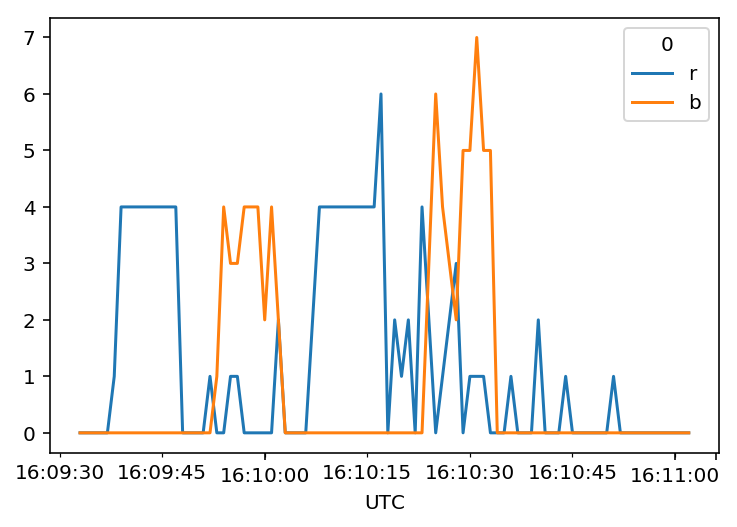

In [7]:
vmstat_timed[['r', 'b']].plot();

## Memory

* swpd: the amount of virtual memory used.
* free: the amount of idle memory.
* buff: the amount of memory used as buffers.
* cache: the amount of memory used as cache.

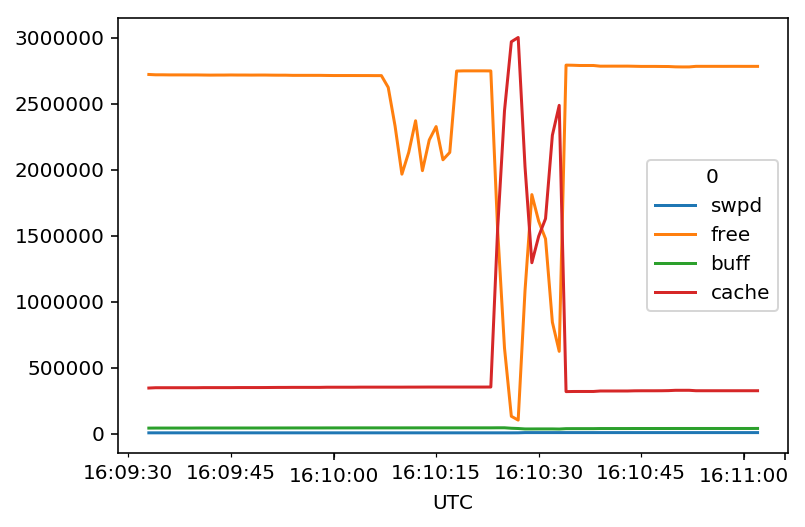

In [8]:
vmstat_timed[['swpd', 'free', 'buff', 'cache']].plot();

## Swap

* si: Amount of memory swapped in from disk (/s).
* so: Amount of memory swapped to disk (/s).



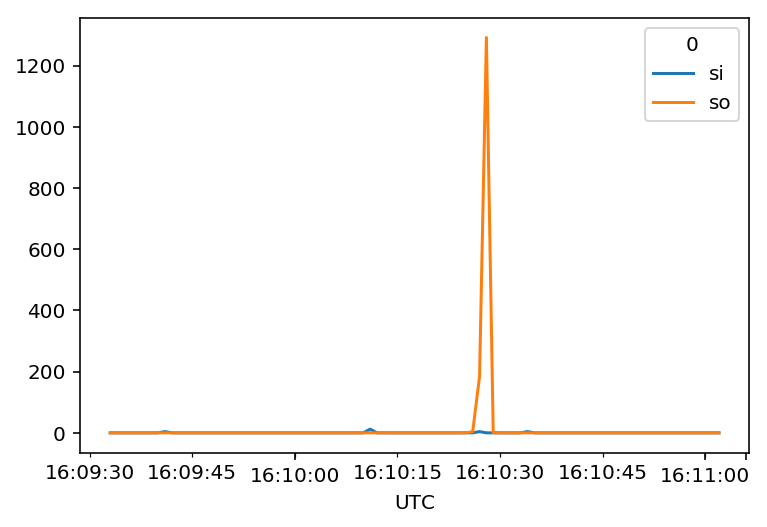

In [9]:
vmstat_timed[['si', 'so']].plot();

## IO
* bi: Blocks received from a block device (blocks/s).
* bo: Blocks sent to a block device (blocks/s).


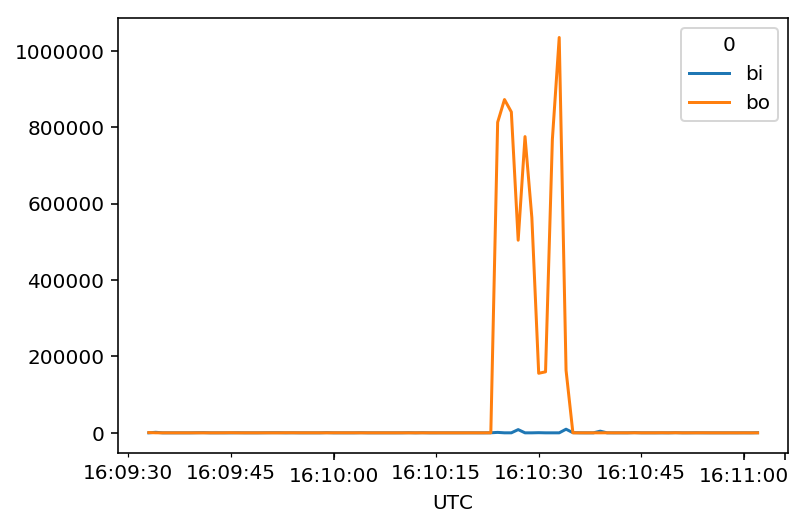

In [10]:
vmstat_timed[['bi', 'bo']].plot();

## System

* in: The number of interrupts per second, including the clock.
* cs: The number of context switches per second.

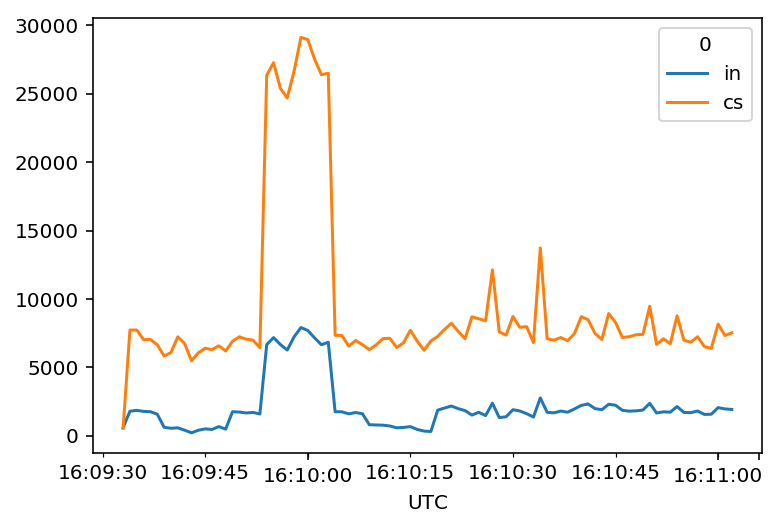

In [11]:
vmstat_timed[['in', 'cs']].plot();

## CPU

These are percentages of total CPU time.

* us: Time spent running non-kernel code. (user time, including nice time)
* sy: Time spent running kernel code. (system time)
* id: Time spent idle. Prior to Linux 2.5.41, this includes IO-wait time.
* wa: Time spent waiting for IO. Prior to Linux 2.5.41, included in idle.
* st: Time stolen from a virtual machine. Prior to Linux 2.6.11, unknown.

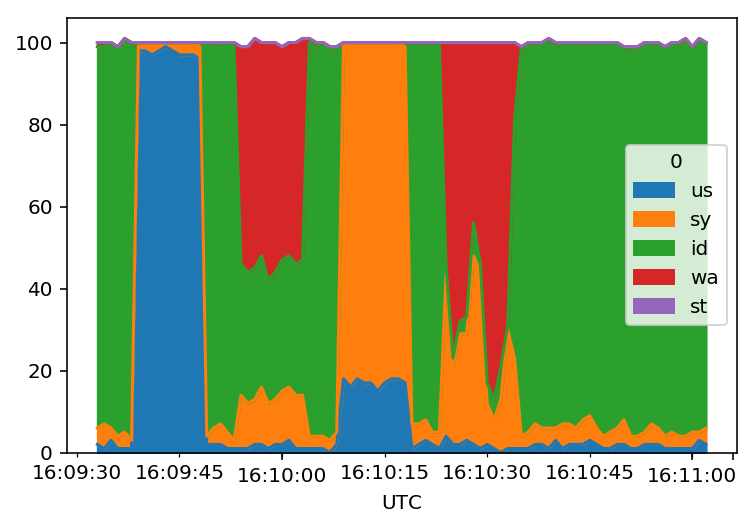

In [12]:
vmstat_timed[['us', 'sy', 'id', 'wa', 'st']].plot.area();